# Time-Series Forecasting

Many projects are happy analysing the past, some also want to predict what will happen based on past data. Time-series forecasting is a very frequent ask when doing streaming analytics. 

Of course this is not trivial, but fortunately there are some ready-made models that you can use as an starting point. This notebook is not a comprehensive work in time-series forecasting, but just a show of what can be achieved. I am using here two of the most lightweight models, so we can train them quickly and execute even in small machines.

We will be doing time-series forecasting reading data from the QuestDB `github_events` table and applying the [Prophet](https://github.com/facebook/prophet?tab=readme-ov-file#installation-in-python---pypi-release) and [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) models.

In [3]:
# we need this line so charts will show in the notebook
%matplotlib widget

# the ML models will throw some warnings that are safe to ignore
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

# Time Series forecasting with Prophet

In [1]:
# Prophet is not installed on the Jupyter Notebook docker image, so we install it first

!pip install prophet

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


from sqlalchemy import create_engine

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

Importing plotly failed. Interactive plots will not work.


We are now getting data aggregated in 1 minutes intervals. In this case we are just tracking the count, but if we have other columns in the dataset we could train the model on those. We are using QuestDB built-in `SAMPLE BY` to aggregate data by timestamp. This is very performant as the downsampling happens directly on the database layer. Otherwise we would need to bring the whole dataset into the notebook and resample locally, which could be prohibitive in the case of very large datasets.

In [6]:
# Query to fetch data from your table
query = 'SELECT timestamp, count() FROM github_events sample by 1m align to calendar'

# Read data into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Data exploration (modify as needed)
print(df.head())
df.columns = [ 'ds', 'y']
df

            timestamp  count
0 2024-02-02 08:05:00    150
1 2024-02-02 08:06:00    180
2 2024-02-02 08:07:00    150
3 2024-02-02 08:08:00    180
4 2024-02-02 08:09:00    150


,ds,y
0,2024-02-02 08:05:00,150
1,2024-02-02 08:06:00,180
2,2024-02-02 08:07:00,150
3,2024-02-02 08:08:00,180
4,2024-02-02 08:09:00,150
...,...,...
89,2024-02-02 09:36:00,180
90,2024-02-02 09:37:00,150
91,2024-02-02 09:38:00,180
92,2024-02-02 09:39:00,150


The next cell is the one properly training the model. Prophet is quite quick to train, so for this demo this should take just a few moments.

In [7]:
# Creating and fitting the Prophet model
model = Prophet()
model.fit(df)

15:21:39 - cmdstanpy - INFO - Chain [1] start processing
15:21:40 - cmdstanpy - INFO - Chain [1] done processing


With a trained model, we can already do predictions. Since we are training with a small slice of data, we will do predictions only for the next 10 minutes, but  that can be easily changed, as you see below.

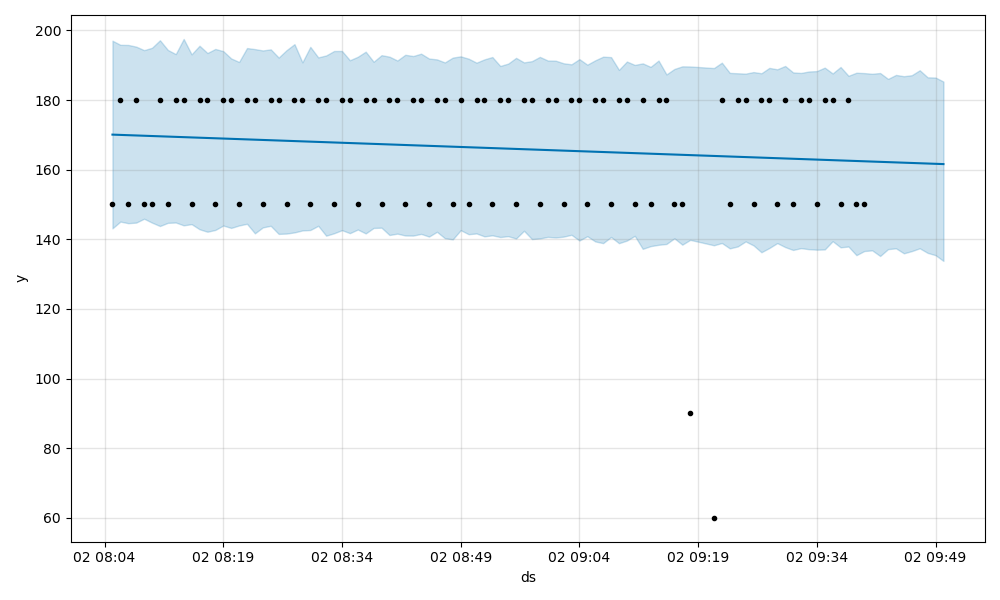

In [8]:
# Making future predictions
#future = model.make_future_dataframe(periods=30)  # Predicting 30 days into the future
future = model.make_future_dataframe(periods=10, freq='T')
forecast = model.predict(future)

# Plotting the forecast
model.plot(forecast)
plt.show()

# Time Series Forecasting with Sklearn and Linear Regression

Now we will do the same prediction using Sklearn with the LinearRegression model. You should notice the predictions for both models look similar, which is the expected outcome as we are doing a very simplistic prediction.

We are sampling the data in 1 minute intervals directly when querying the database, which is convenient, and then we are indexing the resulting Pandas dataframe by timestamp, because the LinearRegression model needs it.

In [10]:
from sqlalchemy import create_engine
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# SQL query to retrieve data from the "github_events" table with downsampling
query = 'SELECT timestamp, count() FROM github_events sample by 1m'

# Execute the query and fetch data into a DataFrame
df = pd.read_sql(query, engine)

# Data preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

We need to prepare the dataframe a little bit, so it will be in the shape that LinearRegression expects

In [11]:
# Create feature (X) and target (y) datasets
X = df.index.to_julian_date().values.reshape(-1, 1)
y = df['count'].values
df

,count
timestamp,
2024-02-02 08:05:12.023344,180
2024-02-02 08:06:12.023344,180
2024-02-02 08:07:12.023344,150
2024-02-02 08:08:12.023344,180
2024-02-02 08:09:12.023344,150
...,...
2024-02-02 09:36:12.023344,180
2024-02-02 09:37:12.023344,150
2024-02-02 09:38:12.023344,180


We can now train the model. LinearRegression should be quite quick to train and this should take just a few seconds.

In [12]:
# Create and fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

And  now we are ready to run predictions and plot a chart. Note we are agin predicting only the next 10 minutes, but if we had data from several months or years we could enlarge the prediction horizon.

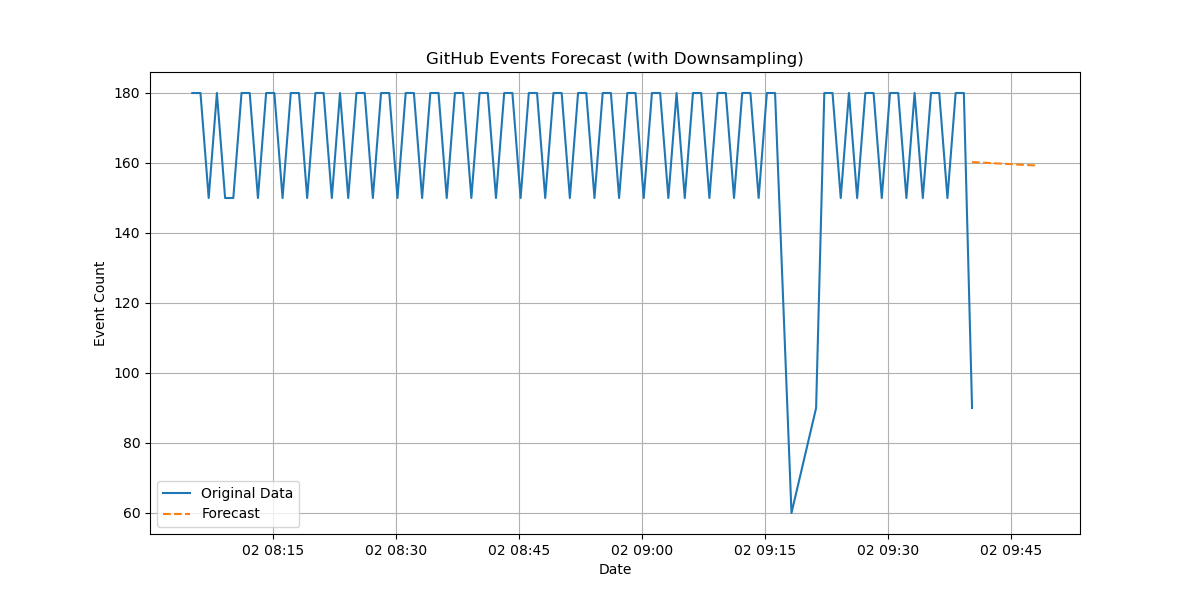

In [13]:
# Predict future values
future_minutes = 10 #30 * 24 * 60  # Number of minutes to forecast (30 days)
future_dates = pd.date_range(start=df.index[-1], periods=future_minutes, freq='T')
future_dates_jd = future_dates.to_julian_date().values.reshape(-1, 1)
future_forecast = model.predict(future_dates_jd)

# Exclude the last known date from the forecast
future_dates = future_dates[:-1]
future_forecast = future_forecast[:-1]

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['count'], label='Original Data')
plt.plot(future_dates, future_forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('GitHub Events Forecast (with Downsampling)')
plt.legend()
plt.grid()
plt.show()